<h1 style="color:rgb(0,120,170)">Artificial Intelligence in Life Sciences</h1>
<h2 style="color:rgb(0,120,170)">Bioactivity Data and Small molecules</h2>

<b>Authors:</b> Luukkonen (based on materials from Klambauer & Rumetshofer) <br>
<b>Date:</b> 06-03-2025

This file is part of the "Artificial Intelligence in Life Sciences" lecture material.
The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational
use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed
or in electronic form, requires explicit prior acceptance of the authors.

In [1]:
# General
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import requests
from io import StringIO

# ChEMBL
from chembl_webresource_client.new_client import new_client

# Chemistry
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*') 
print(rdkit.__version__)


import warnings
warnings.filterwarnings("ignore")

2023.09.5


<h1 style="color:rgb(0,120,170)">Molecule dataset with bioactivity values</h1>

- [ChEMBL:](https://www.ebi.ac.uk/chembl/)
    - Manually curated database of bioactive molecules with drug-like properties.
- [PubChem:](hhttps://pubchem.ncbi.nlm.nih.gov/)
    - Chemical database maintained by the National Center for Biotechnology Information
    - Provides biological activities, chemical structures, and properties of small molecules
- [Papyrus:](https://github.com/OlivierBeq/Papyrus-scripts/tree/master)
    - Large scale curated dataset aimed at bioactivity predictions.

<h2 style="color:rgb(0,120,170)">PuChem</h2>

[PubChem](https://pubchem.ncbi.nlm.nih.gov) is a free and open-access database maintained by the National Center for Biotechnology Information (NCBI). It provides comprehensive information on chemical compounds, including their structures, properties, biological activities, and links to scientific literature. With over 100 million chemical entries, PubChem is a vital resource for researchers in chemistry, biochemistry, and drug discovery.
New chat

<div align="center">
<br>
<img src="resources/PubChem_sources.png" width="400"/>
<img src="resources/pubchem.png" width="600"/>

</div>


The [Adenosine A2A receptor](https://en.wikipedia.org/wiki/Adenosine_A2A_receptor) that plays a key role in regulating inflammation, cardiovascular function, and neurotransmission, particularly in the brain. It is a highly attractive drug target due to its involvement in conditions such as Parkinson's disease, cancer immunotherapy, and inflammatory disorders. Targeting A2A receptors offers the potential to modulate immune responses, enhance neuroprotection, and improve therapeutic outcomes in a variety of diseases.

Thus let's get some bioactivity data for this target! Let's start by getting all assays ids related to this target and retrieve the activity datapoints for these assays:

In [120]:
# Let's start by defining the target protein
uniprot_id = "P29274"  

# Get all the available bioassays for the target protein
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/target/accession/{uniprot_id}/aids/TXT"
response = requests.get(url)
assay_ids = response.text.splitlines()
print(f"Found {len(assay_ids)} bioassays for the target protein")

# Batch process assay IDs (e.g., in chunks of 100 to avoid overloading the server)
batch_size = 100
single_target_assay_data = []

for i in tqdm(range(0, len(assay_ids), batch_size)):
    batch = assay_ids[i:i + batch_size]
    assay_ids_str = ",".join(map(str, batch))
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/{assay_ids_str}/concise/CSV"
    
    # Fetch data for the batch
    response = requests.get(url)
    if response.status_code == 200:
        df = pd.read_csv(StringIO(response.text))
        single_target_assay_data.append(df)
    else:
        print(f"Failed to fetch data for batch: {aid}")

df_pubchem = pd.concat(single_target_assay_data, ignore_index=True)
print(f"Retrieved data for {len(df_pubchem)} bioassays")

Found 1582 bioassays for the target protein


100%|██████████| 16/16 [00:20<00:00,  1.30s/it]

Retrieved data for 27573 bioassays


Let's see what did we get...

In [104]:
df_pubchem

,AID,SID,CID,Activity Outcome,Target Accession,Target GeneID,Activity Value [uM],Activity Name,Assay Name,Assay Type,PubMed ID,RNAi
0,1433,50100086,11485656.0,Active,AAC77369,6795.0,0.071000,NaN,Kinase Inhibitor Selectivity Profiling Assay,Other,NaN,NaN
1,1433,50100086,11485656.0,Active,NP_000450,7010.0,0.450000,NaN,Kinase Inhibitor Selectivity Profiling Assay,Other,NaN,NaN
2,1433,50100086,11485656.0,Active,NP_001690,558.0,0.340000,NaN,Kinase Inhibitor Selectivity Profiling Assay,Other,NaN,NaN
3,1433,50100086,11485656.0,Active,NP_001790,1022.0,2.900000,NaN,Kinase Inhibitor Selectivity Profiling Assay,Other,NaN,NaN
4,1433,50100086,11485656.0,Active,NP_002022,2444.0,0.400000,NaN,Kinase Inhibitor Selectivity Profiling Assay,Other,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
57065,2060392,505365614,155241082.0,Active,P00533,NaN,0.000156,IC50,Exon20-Mutant-EGFR(V769_D770insASV) Kinase Ass...,Confirmatory,NaN,NaN
57066,2060392,505365615,155241082.0,Active,P00533,NaN,0.000107,IC50,Exon20-Mutant-EGFR(V769_D770insASV) Kinase Ass...,Confirmatory,NaN,NaN
57067,2060392,505365616,155241153.0,Active,P00533,NaN,0.000187,IC50,Exon20-Mutant-EGFR(V769_D770insASV) Kinase Ass...,Confirmatory,NaN,NaN
57068,2060392,505365617,155241213.0,Active,P00533,NaN,0.000135,IC50,Exon20-Mutant-EGFR(V769_D770insASV) Kinase Ass...,Confirmatory,NaN,NaN


... it's a bit of an mess. For example:
- Assays 1788 seems to have multiple targets
- Assays 27568 and 27569 seem to have unit error in 'Activity Value [uM]'
- Assays 27570, 27571 and 27572 seem to have no activity information at all

Using all/most of this data will require a lot of manual curation and verification. 

So with PubChem you typically work per assay instead of per target, but that limits your data and only a few assays have enough data to build models as most have only a few or a single datapoint:

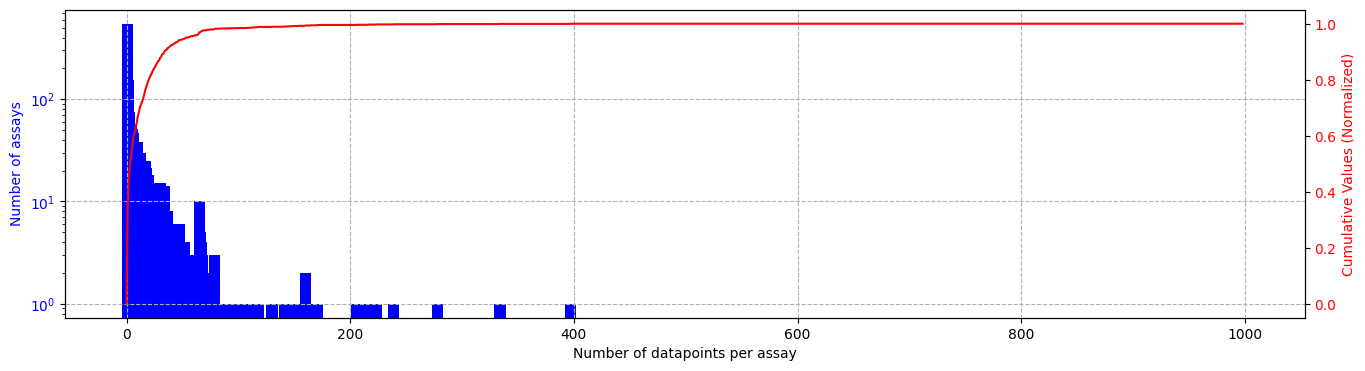

In [121]:
fig, ax1 = plt.subplots(figsize=(16, 4))

# Plot the primary data (values)
hist, bins = np.histogram(df_pubchem['AID'].value_counts(), bins=np.arange(0, 1000, 1))
ax1.bar(bins[:-1], hist, width=10, color='blue', label='Number of datapoints per assay')
ax1.set_xlabel("Number of datapoints per assay")
ax1.set_ylabel("Number of assays", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for cumulative values
ax2 = ax1.twinx()
ax2.plot(bins[:-1], np.cumsum(hist) / np.sum(hist), color='red', label='Cumulative Values (Normalized)')
ax2.set_ylabel("Cumulative Values (Normalized)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set log scale for the primary y-axis
ax1.set_yscale("log")
ax1.grid(linestyle="--")

<h2 style="color:rgb(0,120,170)">ChEMBL</h2>

ChEMBL is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs.

<div align="center">
<br>
<img src="resources/chembl.png" width="500"/>
<img src="resources/ChEMBL_web_service_scheme.jpg" width="535"/>
</div>


Let's download all bioactivity data points for ([AA2AR](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL251/)) in ChEMBL:

In [163]:
bioactivities_api = new_client.activity

bioactivities = bioactivities_api.filter(
    target_chembl_id = 'CHEMBL251', # ChEMBL target id of AA2AR
    # type = 'IC50',  # Measurement type
    # relation = '=', # Only exact measures
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
    "pchembl_value",
)


print(f"Number of datapoints: {len(bioactivities)}")
df_chembl = pd.read_csv('resources/chembl_aa2ar_data.csv')

Number of datapoints: 16636


Each entry in our bioactivity set holds the following information:

In [164]:
bioactivities[10]

{'activity_id': 42217,
 'assay_chembl_id': 'CHEMBL644471',
 'assay_description': 'Antagonist activity against recombinant human adenosine A2A receptor expressed in HEK293 cells in presence of [125I]iodo-ZM-241385 radioligand.',
 'assay_type': 'F',
 'molecule_chembl_id': 'CHEMBL277386',
 'pchembl_value': '6.62',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '238.0',
 'target_chembl_id': 'CHEMBL251',
 'target_organism': 'Homo sapiens',
 'type': 'Ki',
 'units': 'nM',
 'value': '238.0'}

And generally, the data looks clearner that in PubChem (no missing values, all datapoints are for the correct target):

In [167]:
df_chembl

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,pchembl_value,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32555,CHEMBL644471,Antagonist activity against recombinant human ...,F,CHEMBL17002,6.95,=,nM,112.0,CHEMBL251,Homo sapiens,Ki,nM,112.0
1,36246,CHEMBL644471,Antagonist activity against recombinant human ...,F,CHEMBL17341,6.37,=,nM,431.0,CHEMBL251,Homo sapiens,Ki,nM,431.0
2,36255,CHEMBL644471,Antagonist activity against recombinant human ...,F,CHEMBL27041,6.22,=,nM,595.0,CHEMBL251,Homo sapiens,Ki,nM,595.0
3,38692,CHEMBL644471,Antagonist activity against recombinant human ...,F,CHEMBL16724,5.62,=,nM,2370.0,CHEMBL251,Homo sapiens,Ki,nM,2370.0
4,38792,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL132806,7.24,=,nM,57.0,CHEMBL251,Homo sapiens,Ki,nM,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16631,25780250,CHEMBL5476523,"Selectivity interaction (Panel of kinases, GPC...",B,CHEMBL5071309,NaN,<,M,4.5,CHEMBL251,Homo sapiens,pXC50,M,4.5
16632,25780432,CHEMBL5476743,Selectivity interaction (Panel of non-epigenet...,B,CHEMBL5070897,NaN,=,%,2.0,CHEMBL251,Homo sapiens,% of inhibition,%,2.0
16633,25780667,CHEMBL5478105,Selectivity interaction (Eurofins CEREP Divers...,B,CHEMBL5085405,NaN,=,%,80.0,CHEMBL251,Homo sapiens,% of control,%,80.0
16634,25787543,CHEMBL5474378,Selectivity interaction (Adenosine 2A receptor...,B,CHEMBL3643413,NaN,>,nM,30000.0,CHEMBL251,Homo sapiens,IC50,uM,30.0


We can see that there have been many different types of assays, with different outputs (e.g., IC50 or Ki) and different units (e.g., nM or %), there both exact values and sensory data and some compounds have been tested several times. So with ChEMBL data too, you usually need to do some curation but it's typically easier.

For example, let's stick to only exact Ki values and take a look at their distribution (we should also verify duplicates and units etc.)

Number of data points: 5542
Lowest concentration: 3.55e-06
Highest concentration: 1269000.0


<Axes: title={'center': 'Ki values distribution'}, xlabel='Ki (nM)', ylabel='Frequency'>

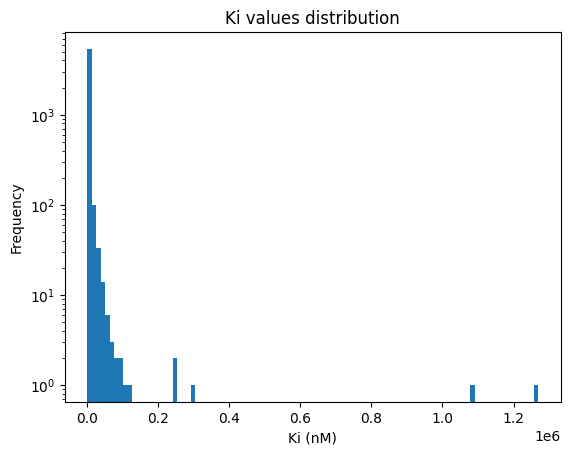

In [171]:
df_ki = df_chembl[(df_chembl['type'] == 'Ki') & (df_chembl['relation'] == '=')]
print(f"Number of data points: {len(df_ki)}")
print(f"Lowest concentration: {df_ki.standard_value.min()}")
print(f"Highest concentration: {df_ki.standard_value.max()}")

df_ki.standard_value.plot(kind='hist', log=True, bins=100, xlabel='Ki (nM)', ylabel='Frequency', title='Ki values distribution')

The distribution has large range but is very bias torwards low values. This is difficult to model!

As a solution the data is often log transformed: $\mathrm{pIC50} = -\log_{10}\mathrm{IC50(M)} = -\log_{10}\mathrm{IC50(nM)^{-9}}$

Let's take a look at the new distribution:

Lowest pKi: 4.0
Highest pKi: 11.0


<Axes: title={'center': 'pKi values distribution'}, xlabel='pKi', ylabel='Frequency'>

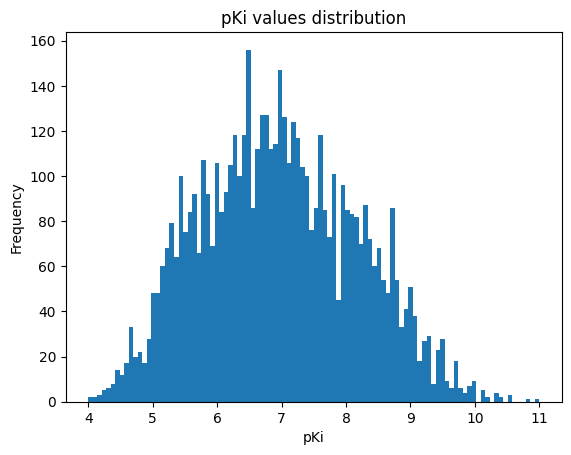

In [172]:
print(f"Lowest pKi: {df_ki.pchembl_value.min()}")
print(f"Highest pKi: {df_ki.pchembl_value.max()}")
df_ki.pchembl_value.plot(kind='hist', bins=100, xlabel='pKi', ylabel='Frequency', title='pKi values distribution')

<h2 style="color:rgb(0,120,170)">Software for small molecule handling</h1>

- [Open Babel:](http://openbabel.org/wiki/Main_Page)
    - Can convert many different file formats
    - Commandline tool, GUIs
    - Calculate 2D, 3D coordinates
    - Some molecular descriptors
- [PaDEL:](http://www.yapcwsoft.com/dd/padeldescriptor/)
    - Java-based ([python wrapper](https://github.com/OlivierBeq/PaDEL_pywrapper))
    - Calculates many molecular descriptors
    - Some molecule handling
- [jCompoundMapper:](http://jcompoundmapper.sourceforge.net/)
    - Java-based
    - Calculates molecular descriptors/fingerprints for machine learning methods
- [ChemAxon:](https://chemaxon.com/)
    - Many different applications for molecules
    - Free academic licences
    - Standardization
    - Chemical descriptors / fingerprints
    - Substructure search
- [Chemopy/chempy:](https://academic.oup.com/bioinformatics/article/29/8/1092/233093)
    - Many molecular descriptors
    - Support stopped?
- [ChemDes:](http://www.scbdd.com/chemdes/)
    - Web-based platform for molecular descriptor and fingerprint computation 

    
- [RDKit:](http://www.rdkit.org/)
    - Python library for handling molecules
    - Offers many functions
    - Many contributors --> bugs and other problems
    - Many users
    - Standard open source tool
    - See usage below

<h1 style="color:rgb(0,120,170)">The MUTAG dataset</h1>

The MUTAG dataset is as small dataset of over 200 molecules tested for mutagenicity (inducing mutations in DNA). More information about the dataset can be found in this publication: <br>
<i> Debnath, A. K., Lopez de Compadre, R. L., Debnath, G., Shusterman, A. J., & Hansch, C. (1991). Structure-activity relationship of mutagenic aromatic and heteroaromatic nitro compounds. correlation with molecular orbital energies and hydrophobicity. Journal of medicinal chemistry, 34(2), 786-797. </i>

In the following we will load this dataset in **MOL/SDF format** and inspect it in more detail. The main blocks of this data format are depicted below:

<div align="center">
<br>
<img src="resources/sdf_format.gif" width="400"/>
Source: http://www.homepages.ed.ac.uk/jjarvis/research/thesis/node50.html 
</div>

In [2]:
# Load Mutag set as text
with open('resources/mutag.sdf') as f:
    mutag_txt = f.read()
    
print(mutag_txt)

2-nitrophenanthrene
csChmFindW1207992328
[comments]
 17 19  0     0  0  0  0  0  0  1 V2000
    0.6533    2.4267    0.0000 C   0  0  0  0  0  0  0  0  0  0
    0.0000    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0
    0.6533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0
    2.0533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0
    2.7533    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0
    2.0533    2.4267    0.0000 C   0  0  0  0  0  0  0  0  0  0
    4.1533    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0
    4.8533    2.4267    0.0000 C   0  0  0  0  0  0  0  0  0  0
    4.1533    3.5933    0.0000 C   0  0  0  0  0  0  0  0  0  0
    2.7533    3.5933    0.0000 C   0  0  0  0  0  0  0  0  0  0
    4.8533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0
    6.2533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0
    7.0000    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0
    6.2533    2.4267    0.0000 C   0  0  0  0  0  0  0  0  0  0
    8.4000  

In [3]:
# Load molecules form SDF to rdkit
mutag = Chem.SDMolSupplier('resources/mutag.sdf')

# Drop invalid compounds
mutag = [mol for mol in mutag if mol != None]

In [4]:
# Select a molecule
mol = mutag[0] 
print(Chem.MolToMolBlock(mol))

2-nitrophenanthrene
     RDKit          2D

 17 19  0  0  0  0  0  0  0  0999 V2000
    0.6533    2.4267    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.6533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.7533    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0533    2.4267    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.1533    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.8533    2.4267    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.1533    3.5933    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.7533    3.5933    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.8533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.2533   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    7.0000    1.2133    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.

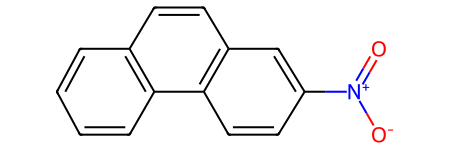

In [5]:
# Visualize the content of the mol object
mol

<h1 style="color:rgb(0,120,170)">Molecular graphs</h1>

A **molecular graph**, or chemical graph, is a representation of the structural formula of a chemical compound in terms of graph theory. A chemical graph is a *undirected labeled graph* whose vertices correspond to the *atoms* of the compound and edges correspond to chemical *bonds*. Its vertices are labeled with the kinds of the corresponding atoms and edges are labeled with the types of bonds.

Typically *hydrogen-depleted molecular graph* are used where the hydrogen vertices deleted.

In [6]:
def drawMolecule(mol, bond_idcs=False, atom_idcs=True, explicit_hydrogens=False):
    """Draw molecular structure with node numbering and explicit hydrogens"""    
    if explicit_hydrogens:
        mol = Chem.AddHs(mol)
    AllChem.Compute2DCoords(mol)
    d2d = Draw.MolDraw2DSVG(350, 300)
    d2d.drawOptions().addAtomIndices = atom_idcs
    d2d.drawOptions().addBondIndices = bond_idcs
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

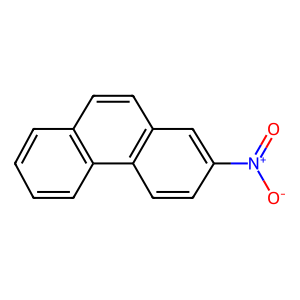

In [7]:
# Visualize molecular graph
mol = mutag[0] 
Draw.MolToImage(mol)

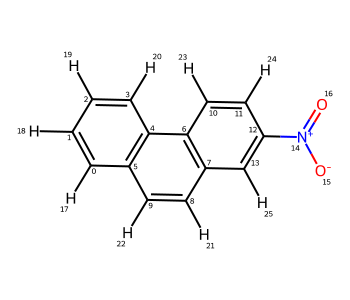

In [8]:
# Print 2D structure with atom indices (starting at 0; contrary to SDF format)
drawMolecule(mol, bond_idcs=False, atom_idcs=True, explicit_hydrogens=True)

<h2 style="color:rgb(0,120,170)">Atoms, bonds and ring information</h2>

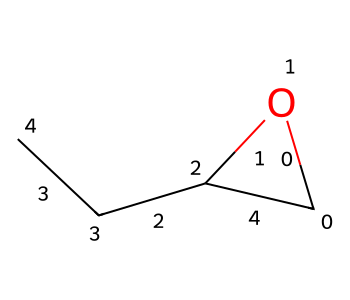

In [9]:
m = Chem.MolFromSmiles('C1OC1CC')

# Print 2D structure with atom indices and bond indices
drawMolecule(m, bond_idcs=True)

In [10]:
# Print atomic numbers of atoms in perodic system
for atom in m.GetAtoms():
    print(atom.GetAtomicNum())

6
8
6
6
6


In [11]:
# Get bond type for bond 0
print(m.GetBonds()[0].GetBondType())

SINGLE


In [12]:
# Check wheter atom 0 is in a ring 
m.GetAtomWithIdx(0).IsInRing()

True

In [13]:
# Check wheter atom 3 is in a ring 
m.GetAtomWithIdx(3).IsInRing()

False

In [14]:
# Check wheter atom 0 is in a ring of size 3
m.GetAtomWithIdx(0).IsInRingSize(3)

True

In [15]:
# Check wheter atom 0 is in a ring of size 4
m.GetAtomWithIdx(0).IsInRingSize(4)

False

<h2 style="color:rgb(0,120,170)">Modifying molecules</h2>

Normally molecules are stored in the RDKit with the hydrogen atoms implicit (e.g. not explicitly present in the molecular graph. It is useful to have the hydrogens explicitly present, for example when generating or optimizing the 3D geometry.

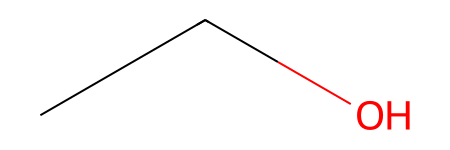

In [16]:
m = Chem.MolFromSmiles('CCO')
m

In [17]:
m.GetNumAtoms()

3

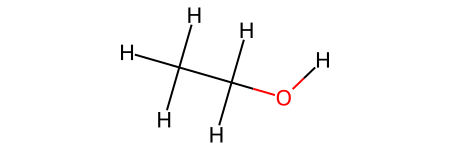

In [18]:
# Adds hydrogens to the graph of the molecule
m2 = Chem.AddHs(m)
m2

In [19]:
m2.GetNumAtoms()

9

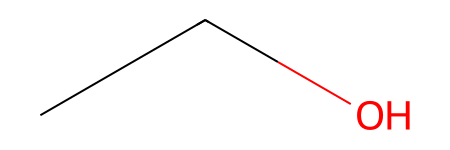

In [20]:
# Returns a copy of the molecule with all Hs removed
m3 = Chem.RemoveHs(m2)
m3

In [21]:
m3.GetNumAtoms()

3

<h2 style="color:rgb(0,120,170)">Aromatic bonds</h2>

[Aromaticity](https://en.wikipedia.org/wiki/Aromaticity) in organic chemistry describes the enhanced stability observed in cyclic arrangements of conjugated bonds, lone pairs, or empty orbitals, first coined by August Wilhelm Hofmann in 1855. This phenomenon, exemplified by benzene, arises from cyclic delocalization and resonance, allowing electrons to freely circulate within a **ring of alternating single and double bonds**, resulting in greater stability than predicted solely by conjugation. 

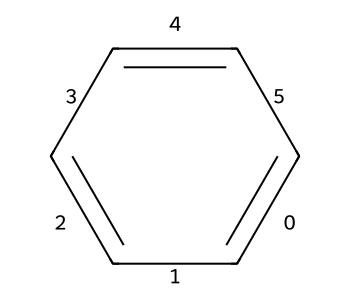

In [22]:
m = Chem.MolFromSmiles('c1ccccc1')
# Print 2D structure with atom indices and bond indices
drawMolecule(m, bond_idcs=True, atom_idcs=False)

In [23]:
# Get bond type for bond 0
m.GetBondWithIdx(0).GetBondType()

rdkit.Chem.rdchem.BondType.AROMATIC

In [24]:
# Get bond type for bond 0
m.GetBondWithIdx(1).GetBondType()

rdkit.Chem.rdchem.BondType.AROMATIC

In [25]:
# Remove aromatic bond information
Chem.Kekulize(m)

In [26]:
# Get bond type for bond 0
m.GetBondWithIdx(0).GetBondType()

rdkit.Chem.rdchem.BondType.DOUBLE

In [27]:
# Get bond type for bond 1
m.GetBondWithIdx(1).GetBondType()

rdkit.Chem.rdchem.BondType.SINGLE

In [28]:
# Resets aromaticity (amongst other things)
Chem.SanitizeMol(m)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

In [29]:
# Get bond type for bond 0
m.GetBondWithIdx(0).GetBondType()

rdkit.Chem.rdchem.BondType.AROMATIC

<h1 style="color:rgb(0,120,170)"> String Representations</h1>

<h2 style="color:rgb(0,120,170)">SMILES (Simplified Molecular Input Line Entry Specification)</h2>

- string representation (not unique)
- single bonds not written, double and triple bonds indicated by = and #
- rings indicated by numbers
- aromaticity indicated by lower case letters
- side chains indicated by brackets

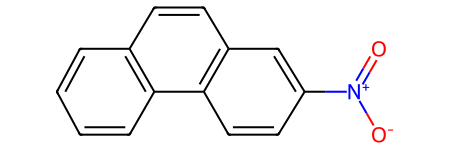

In [30]:
mol

In [31]:
# Canonical SMILES (attempt to have an unique SMILES)
smi0 = Chem.MolToSmiles(mol)
smi0

'O=[N+]([O-])c1ccc2c(ccc3ccccc32)c1'

In [32]:
# Other smiles representation of the same molecule
smi1 = Chem.MolToSmiles(mol, doRandom=True)
smi2 = Chem.MolToSmiles(mol, doRandom=True)
smi1, smi2

('c1c2c(c3ccccc3cc2)ccc1[N+]([O-])=O', 'c1c(cc2ccc3ccccc3c2c1)[N+](=O)[O-]')

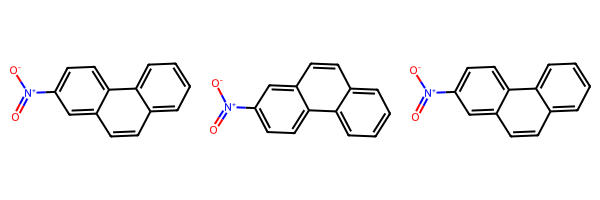

In [33]:
# Visual check
mols = [Chem.MolFromSmiles(smi) for smi in [smi0, smi1, smi2]]
Draw.MolsToGridImage(mols)

<h2 style="color:rgb(0,120,170)">InChI (International Chemical Identifier)</h2>

The International Chemical Identifier (InChI) is a textual identifier for chemical substances, designed to provide a standard way to encode molecular information and to facilitate the search for such information in databases and on the web.

<div align="center">
<br>
<img src="resources/inchi.png" width="800"/>
Source: https://www.inchi-trust.org/technical-faq-2/#2.1 
</div>

In [34]:
# Convert mol to InChI
Chem.MolToInchi(mol)

'InChI=1S/C14H9NO2/c16-15(17)12-7-8-14-11(9-12)6-5-10-3-1-2-4-13(10)14/h1-9H'

<h3 style="color:rgb(0,120,170)">InChIKey</h3>

- Hashed version of InChI
- Fixed-length of 27 characters
- Cannot be converted back to rdkit molecule
- Not unique (but collisions are extremly rare)

In [35]:
# Convert mol to InChIKey
Chem.MolToInchiKey(mol)

'PYZVVHPEDWRKME-UHFFFAOYSA-N'

<h2 style="color:rgb(0,120,170)">SMARTS - substructure matching</h2>

SMILES arbitrary target specification (SMARTS) is a language for specifying substructural patterns in molecules. 

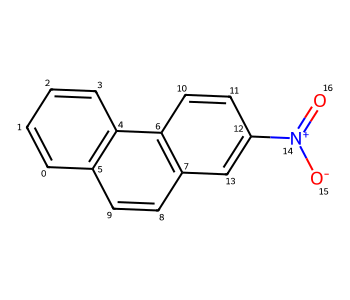

In [36]:
m = Chem.MolFromSmiles('c1ccccc1O')

# Print 2D structure with atom indices 
drawMolecule(mol)

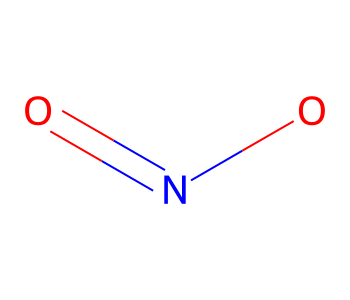

In [37]:
# Substructure 
patt = Chem.MolFromSmarts('N(-O)=O')
drawMolecule(patt, atom_idcs=False)

In [38]:
# Check if molecule contains substructre
mol.HasSubstructMatch(patt)

True

In [39]:
# Get atom indices of substructure
mol.GetSubstructMatch(patt)

(14, 15, 16)

You can use logical operations during the search:

In [40]:
# Check for molecules in Mutag that contain Fluorine or Chlorine
patt = Chem.MolFromSmarts('[F,#17]') # F = fluorine, #17 = Cl = chlorine
matches = []
for mol in mutag:
    if mol is not None and mol.HasSubstructMatch(patt):
        matches.append(mol)

In [41]:
matches

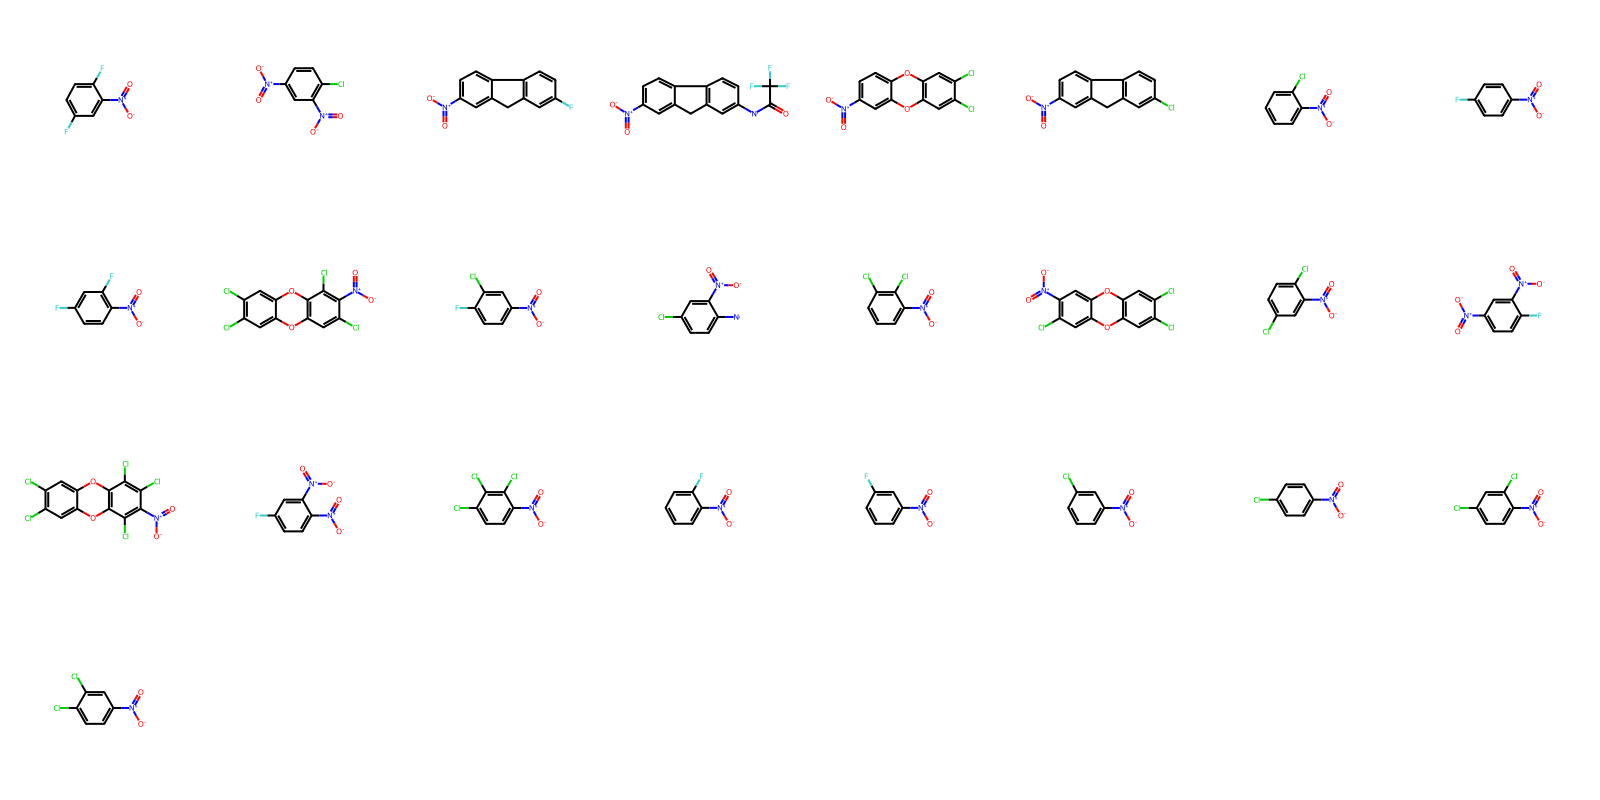

In [42]:
Draw._MolsToGridImage(matches,molsPerRow=8)

<h1 style="color:rgb(0,120,170)">Molecular descriptors</h1>

<blockquote cite="Todeschini, Roberto; Consonni, Viviana (2000). Handbook of Molecular Descriptors">The molecular descriptor is the final result of a logic and mathematical procedure which transforms chemical information encoded within a symbolic representation of a molecule into a useful number or the result of some standardized experiment.</blockquote>

<h2 style="color:rgb(0,120,170)">RDKIT Descriptors</h2>

In [43]:
# Define descriptors that should be calculated (we select all available)
descriptor_list = Chem.Descriptors._descList
print('Number of descriptors:', len(descriptor_list))
print(descriptor_list[:5])

Number of descriptors: 210
[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x0000022C085153F0>), ('MaxEStateIndex', <function MaxEStateIndex at 0x0000022C085152D0>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x0000022C08515480>), ('MinEStateIndex', <function MinEStateIndex at 0x0000022C08515360>), ('qed', <function qed at 0x0000022C08540280>)]


In [44]:
def getMolDescriptors(mol, missingVal=None):
    '''
    Calculate the full list of descriptors for a molecule. missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Chem.Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        res['Name'] = mol.GetProp('_Name')
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [45]:
getMolDescriptors(mol)

{'Name': 'furazolidone',
 'MaxAbsEStateIndex': 10.96008204207609,
 'MaxEStateIndex': 10.96008204207609,
 'MinAbsEStateIndex': 0.20037037037037053,
 'MinEStateIndex': -0.6513310185185182,
 'qed': 0.43330977201829607,
 'SPS': 15.75,
 'MolWt': 225.15999999999994,
 'HeavyAtomMolWt': 218.10399999999998,
 'ExactMolWt': 225.038570324,
 'NumValenceElectrons': 84,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.4330616376615302,
 'MinPartialCharge': -0.44617452407140373,
 'MaxAbsPartialCharge': 0.44617452407140373,
 'MinAbsPartialCharge': 0.4330616376615302,
 'FpDensityMorgan1': 1.5625,
 'FpDensityMorgan2': 2.375,
 'FpDensityMorgan3': 2.9375,
 'BCUT2D_MWHI': 16.648672405315363,
 'BCUT2D_MWLOW': 10.475289385558526,
 'BCUT2D_CHGHI': 2.2049868560259718,
 'BCUT2D_CHGLO': -2.0129419876989085,
 'BCUT2D_LOGPHI': 2.138862692827102,
 'BCUT2D_LOGPLOW': -2.168449468832695,
 'BCUT2D_MRHI': 5.780519849644527,
 'BCUT2D_MRLOW': -0.4017297873652768,
 'AvgIpc': 2.834794765151926,
 'BalabanJ': 2.05070916792667

In [46]:
# Compute all rdkit descriptors for molecules in mutag dataset
mutag_descriptors = [getMolDescriptors(m) for m in mutag if m != None]
df = pd.DataFrame(mutag_descriptors)

df

,Name,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,2-nitrophenanthrene,10.713762,10.713762,0.132205,-0.366438,0.356442,10.823529,223.231,214.159,223.063329,...,0,0,0,0,0,0,0,0,0,0
1,8-nitroquinoline,10.580467,10.580467,0.053796,-0.421296,0.491211,10.153846,174.159,168.111,174.042927,...,0,0,0,0,0,0,0,0,0,0
2,5-nitroquinoline,10.592689,10.592689,0.102407,-0.398796,0.491211,10.153846,174.159,168.111,174.042927,...,0,0,0,0,0,0,0,0,0,0
3,1-nitrofluoranthene,11.262839,11.262839,0.185093,-0.297963,0.369424,11.578947,247.253,238.181,247.063329,...,0,0,0,0,0,0,0,0,0,0
4,"2,5-difluoronitrobenzene",12.412037,12.412037,0.537037,-1.031111,0.463316,9.636364,159.091,156.067,159.013185,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,5-nitro-2-furanacrolein,10.106231,10.106231,0.285926,-0.640625,0.294905,10.333333,167.120,162.080,167.021858,...,0,0,0,0,0,0,0,0,0,0
214,nitrofurazone,10.146041,10.146041,0.057130,-1.456198,0.390841,10.285714,195.114,192.090,195.015430,...,0,0,0,0,0,0,0,0,0,1
215,nitrofurantoin,11.005221,11.005221,0.100786,-0.771013,0.318916,15.647059,237.151,232.111,237.025994,...,0,0,0,0,0,0,0,0,0,1
216,niridazole,11.109911,11.109911,0.069722,-0.528912,0.530806,15.714286,213.198,208.158,213.008236,...,0,0,0,0,0,1,0,0,0,1


In [47]:
# List of available descriptions for the descriptors
MoleculeDescriptors.MolecularDescriptorCalculator([desc[0] for desc in descriptor_list]).GetDescriptorSummaries()

['N/A',
 'N/A',
 'N/A',
 'N/A',
 'Calculate the weighted sum of ADS mapped properties',
 'Calculates the SpacialScore descriptor. By default, the score is normalized by the number of heavy atoms (nSPS) resulting in a float value, otherwise (normalize=False) the absolute score is returned as an integer.',
 'The average molecular weight of the molecule',
 'The average molecular weight of the molecule ignoring hydrogens',
 'The exact molecular weight of the molecule',
 'The number of valence electrons the molecule has',
 'The number of radical electrons the molecule has (says nothing about spin state)',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'This returns the average information content of the coefficients of the characteristic polynomial of the adjacency matrix of a hydrogen-suppressed graph of a molecule.',
 "Calculate Balaban's J value for a molecule",
 'A topological index meant to quantify "complexity" 

<h2 style="color:rgb(0,120,170)">Morgan Fingerprints</h2>

Morgan fingerprints, also known as circular fingerprints, are a type of molecular fingerprinting method used in cheminformatics and computational chemistry to represent the structural features of a molecule based on its atom environments within a given radius. These fingerprints encode information about the presence or absence of specific substructures.

In [48]:
from rdkit.Chem import rdFingerprintGenerator 

# Set up fingerprint generator
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)

In [49]:
# Generate binary fingeprint
fp = mfpgen.GetFingerprint(mol)
fp, np.array(fp)

(<rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x22c087dac00>,
 array([0, 0, 0, ..., 0, 0, 0]))

In [50]:
# Directly to np with: 
mfpgen.GetFingerprintAsNumPy(mol)

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [51]:
# Generate count fingerprint
mfpgen.GetCountFingerprintAsNumPy(mol)

array([0, 0, 0, ..., 0, 0, 0], dtype=uint32)

In [52]:
# Compute fingeprints for all mutag compounds
fps = np.array([mfpgen.GetFingerprint(mol) for mol in mutag])
names = [mol.GetProp('_Name') for mol in mutag]
df = pd.DataFrame(fps, index=names)
df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
2-nitrophenanthrene,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8-nitroquinoline,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-nitroquinoline,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1-nitrofluoranthene,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
"2,5-difluoronitrobenzene",0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5-nitro-2-furanacrolein,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nitrofurazone,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
nitrofurantoin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
niridazole,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


<h2 style="color:rgb(0,120,170)">MACCS keys</h2>

MACCS keys, or Molecular ACCess System keys, are a set of 166 structural keys or binary fingerprints used in cheminformatics to encode the presence or absence of specific substructural features (expert selected SMART patterns) in a molecule. 

In [53]:
from rdkit.Chem import MACCSkeys
keys = MACCSkeys.GenMACCSKeys(mol)
keys, np.array(keys)

(<rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x22c087da570>,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0]))

In [54]:
# Compute MACCS keys for all mutag compounds
fps = np.array([MACCSkeys.GenMACCSKeys(mol) for mol in mutag])
names = [mol.GetProp('_Name') for mol in mutag]
df = pd.DataFrame(fps, index=names)
df

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
2-nitrophenanthrene,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
8-nitroquinoline,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
5-nitroquinoline,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
1-nitrofluoranthene,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
"2,5-difluoronitrobenzene",0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5-nitro-2-furanacrolein,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,1,1,0
nitrofurazone,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,1,1,0
nitrofurantoin,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,1,1,0
niridazole,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,1,1,0


<h1 style="color:rgb(0,120,170)">Further info/examples</h1>

- [Teachopencadd T001: Query ChEMBL](https://github.com/volkamerlab/teachopencadd/tree/master/teachopencadd/talktorials/T001_query_chembl)
- [Papyrus: Simple examples](https://github.com/OlivierBeq/Papyrus-scripts/blob/master/notebook_examples/simple_examples.ipynb) 
- [Exploring Chemical Information in PubChem](https://currentprotocols.onlinelibrary.wiley.com/doi/10.1002/cpz1.217)
- [Teachopencadd T033: Molecular representations](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T033_molecular_representations)
- [rdkit's FingerprintGenerator tutorial](https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html)